# Homework 6: Image Classification with Keras

The homework consists of two parts: theoretical part (7 pts) and coding part (16.5+10 pts).
 - All theoretical questions must be answered in your own words, do not copy-paste text from the internet. Points can be deducted for terrible formatting or incomprehensible English.
 - Code must be commented. If you use code you found online, you have to add the link to the source you used. There is no penalty for using outside sources as long as you convince us you understand the code.

**Note that coding part consists of two different notebooks.**

*Once completed zip the entire directory containing this exercise and upload it to https://courses.cs.ut.ee/2020/nn/spring/Main/Practices.*

**If you did this homework together with course mates, please write here their names (answers still have to be your own!).**

**Name(s):** fill this in if applicable

## Part 1: Theory Exercises

These theoretical questions are about the material covered in the lecture about "Recurrent Neural Networks".

**Task 1.1 (7pts):** Recurrent networks: basic truths and architectures

Which of the following is true about recurrent neural networks. In case of ”True” bring
an example (e.g. suffices to refer to a slide in lecture), in case of ”False”, explain.

1. A recurrent network always produces one output prediction per timestep. \
   **True**, in case on vanilla RNN that outputs predictions right after each hidden state.
2. It is possible to put a convolutional layer between the input and the recurrent layer. \
   **True**, vector-to-sequence, caption generation.
3. The final layer (that makes the classification/regression) must be connected directly to the recurrent layer. \
   **True**, Summarization.
4. In all RNNs types seen in the lecture, output produced at timestep t can only depend on inputs received at timesteps 0 to t, and not on future timesteps. \
   **False**, Bidirectional RNN uses states at future timesteps for the past outputs.
5. All layers of a recurrent neural network are recurrent. \
   **False**, output layer does not depend on previous outputs.
6. Only one layer of the recurrent network can be recurrent (two recurrent layers would make no sense). \
   **False**, additional recurrent layers provide more hidden states and more representational power (DRNN, BRNN).
7. The activations of the hidden nodes stay the same across all timesteps. \
   **False**, different activations are produced by hidden nodes at all timesteps.
8. Different timesteps use the exact same weight matrices only in recurrent layers. This does not apply to other layers. \
   **False**, input and output layers also share the same weight matrices.
9. Different timesteps use the exact same weight matrices. This applies to all layers. \
   **True**, Vanilla RNN.
10. Gradient clipping is important to battle against gradients getting weaker and weaker. \
   **False**, it is important to battle against gradient explosions.
11. LSTM networks deal with long term dependencies better than simple RNNs, because they have less parameters. \
   **False**, they deal better because of a short-term loop preserving hidden states through timesteps.
12. The gates in LSTM are opened or closed depending on the current input and current hidden state and it does not matter which timestep it currently is. \
   **False**, the LSTM gates also depend on timesteps, concretely on the hidden state and input values at the particular timesteps.
13. I have trained my network to predict the weather on the 8th day based on the weather of previous 7 days. I now have weather from only past 5 days available. I can still use the same network to predict weather tomorrow (accuracy might be bad, but we can use fewer inputs without changing the network). \
   **True**, because RNNs take a sequence of arbitrary length as an input, not a vector, that's why it's possible to use the 5 days weather data in this case, although it was trained on 7 days sequence.
14. I can train a recurrent network to receive input only at the first timestep and then produce arbitrarily long sequence of outputs. \
   **True**, one-to-many networks for music generation.

## Practical Exercises

You've written a lot of code in this course to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of the course, though, we're going to leave behind your beautiful codebase and instead migrate to a popular deep learning framework: [Keras](https://keras.io/). Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. Keras has very well designed API, which allows for concise code and flexibility at the same time.

### Installation

#### Linux

To install Keras enter following on Conda command-line:
```
conda install keras
```

By default Keras uses Tensorflow backend. If you happen to have recent NVidia GPU on your machine, you might want to install GPU version of Tensorflow:
```
conda install tensorflow-gpu
```
When you import Keras in your code, you should see "Using TensorFlow backend." notice.

PS. If you have non-NVidia GPU, you might want to give a shot to [PlaidML](http://vertex.ai/blog/announcing-plaidml) Keras backend.

#### Windows

To install Keras enter following on Conda command-line:
```
pip install keras
```
By default Keras uses Tensorflow backend. If you happen to have recent NVidia GPU on your machine, you might want to install GPU version of Tensorflow:
```
pip install tensorflow-gpu
```
When you import Keras in your code, you should see "Using TensorFlow backend." notice.

#### In case you face some problems
If you see an error about tensorflow or that "Softmax does not have axis argument", run the following line:
```
pip install tensorflow==1.12.0
```

If you get an error with Numpy, make sure you have the last version by running:
```
pip intall -U numpy
```

When working with the notebook `Network.ipynb`, if you have a problem importing `from keras.applications.imagenet_utils import CLASS_INDEX`, then you can use `keras_applications`:
```
pip install keras_applications==1.0.7
```
and tehn replace the line
```
from keras.applications.imagenet_utils import CLASS_INDEX
```
with
```
from keras_applications.imagenet_utils import CLASS_INDEX
```

**Note:** if with all this you are still in trouble, you can create a new environment with the `requirements.txt` file. This file contains the required packages and has been tested with this notebook.
```
conda create  python=3.6 --name neural_networks_env
source activate neural_networks_env
conda install --file practice6/requirements.txt
```
then make sure that the kernel you use in jupyer is neural_networks_env

In [7]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Loading Data

Keras includes builtin support for datasets like MNIST, CIFAR, etc.
The first time you load a dataset it might take some time to download.

In [8]:
from keras.datasets import cifar10

# Keras comes with built-in loaders for common datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# shorten dataset for quicker training
# feel free to comment those out if you have GPU
X_train = X_train[:25000]
y_train = y_train[:25000]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (25000, 32, 32, 3)
Train labels shape:  (25000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


### First model

Keras has two options for creating models: [sequential](https://keras.io/getting-started/sequential-model-guide/) and [functional API](https://keras.io/getting-started/functional-api-guide/). We are going to use functional API, because it matches well with computational graph model what neural networks really are. Also functional API allows branching, layer sharing and other advanced features we might need later.

Study the following code and see how we first create input tensor `x`, then apply layers to intermediate tensors until we produce tensor of probabilities `p`. Layers are implemented as [functors](https://www.daniweb.com/programming/software-development/threads/485098/functors-in-python) in Keras, meaning they are objects that can be called as functions. You can print out intermediate tensors `h` to see their shapes. Remember, here we just define the computational graph, no calculations are made yet. For more information see Keras documentation:
 - [Core layers](https://keras.io/layers/core/)
 - [Convolutional layers](https://keras.io/layers/convolutional/)
 - [Activations](https://keras.io/activations/)

Then the model is created with `x` as input and `p` as output. Cross-entropy loss is applied to the network with Adam optimizer and additional accuracy metric. `sparse_categorical_crossentropy` loss allows us to pass integer class values directly as targets and is potentially more efficient than `categorical_crossentropy`, which needs one-hot vectors as targets. For more information see Keras documentation:
 - [Losses](https://keras.io/losses/)
 - [Optimizers](https://keras.io/optimizers/)
 - [Metrics](https://keras.io/metrics/)

`model.summary()` prints out layer list with output shapes and is very useful for debugging the model. Also it shows number of trainable parameters, which is useful metric to estimate the capacity of your network.

In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, Activation, Flatten, Dense
from keras.optimizers import Adam

# We first need to define the sequence of dependencies (the computational graph)
x = Input(shape=(32, 32, 3))
h = Conv2D(32, (7, 7), strides=(2, 2))(x)
h = Activation('relu')(h)
h = Flatten()(h)
h = Dense(10)(h)
p = Activation('softmax')(h)

# Now that we have defined how to find p from x, we can create a 
# model simply by saying what is input and what is output
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4736      
_________________________________________________________________
activation_3 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 58,826
Trainable params: 58,826
Non-trainable params: 0
_______________________________________________________

**Task 2.1 (1pt):** Why accuracy cannot be used as a loss function?

**Your answer:** During training we want to minimize loss to be as close to 0 as possible, meaning that 0 loss would be a perfect case. However, 0 accuracy is the worst case to happen, because it would mean the model doesn't predict any samples correctly. Thus, this inconsistency doesn't allow accuracy to be used as a loss function.

### First training

Now we train our first model in Keras. Keras follows simple style similar to Scikit-learn, where a model has methods `fit()`, `predict()` and `evaluate()`. Notice how we use `validation_split` parameter to automatically produce validation set that is 4% of the whole dataset.

In [10]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.04)

Train on 24000 samples, validate on 1000 samples
Epoch 1/5
24000/24000 [==============================] - 4s 174us/step - loss: 32.5077 - accuracy: 0.1353 - val_loss: 20.9713 - val_accuracy: 0.1740
Epoch 2/5
24000/24000 [==============================] - 3s 140us/step - loss: 18.7758 - accuracy: 0.1793 - val_loss: 16.4415 - val_accuracy: 0.2040
Epoch 3/5
24000/24000 [==============================] - 3s 138us/step - loss: 15.1984 - accuracy: 0.2078 - val_loss: 13.7737 - val_accuracy: 0.2260
Epoch 4/5
24000/24000 [==============================] - 4s 151us/step - loss: 12.9969 - accuracy: 0.2231 - val_loss: 11.9950 - val_accuracy: 0.2630
Epoch 5/5
24000/24000 [==============================] - 4s 147us/step - loss: 11.4057 - accuracy: 0.2378 - val_loss: 10.7688 - val_accuracy: 0.2670


`History` object returned by `model.fit()` can be used to plot learning curves.

training loss std = 7.580037286590153
validation loss std = 3.63184103129549


Text(0.5,1,'Accuracy')

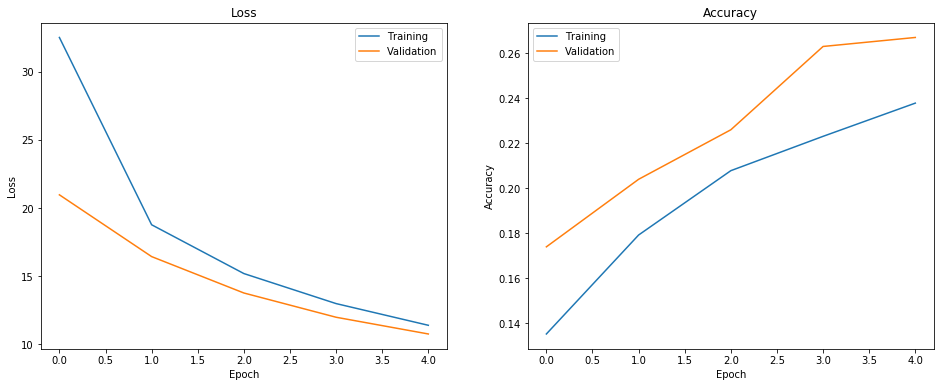

In [15]:
plt.figure(figsize=(16, 6))

print('training loss std =', np.array(history.history['loss']).std())
print('validation loss std =', np.array(history.history['val_loss']).std())

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

**Task 2.2 (1pt):** Why training set accuracy is lower than validation set accuracy in the first epochs? Hint: training accuracy is an average over all training batches in epoch. When is validation accuracy calculated?

**Your answer:** The training set has a larger amount of samples as well as the variation of the samples compared to the validation set, that's why the model performs worse in average on a larger set of samples. Validation accuracy is calculated after each epoch.

We can use model `predict()` method to produce predictions on given dataset.

In [16]:
y_hat = model.predict(X_test)
y_pred = np.argmax(y_hat, axis=1)
print("Test set accuracy:", np.mean(y_pred == y_test[:, 0]))

Test set accuracy: 0.2326


But if we just want to evaluate the metrics and losses, it's easier to use `evaluate()` method.

In [17]:
# IPython notebook just prints out the returned values - loss and accuracy
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 92us/step


[11.282167637634277, 0.23260000348091125]

In [18]:
# the same for training set
model.evaluate(X_train, y_train)

25000/25000 [==============================] - 2s 98us/step


[10.77068780670166, 0.24344000220298767]

### Data Normalization

The above results were not very impressive. What are we missing? It turns out neural networks work much better with normalized inputs, which are around 0 (the most effective region of activation function).

We are going to try out three different normalization methods:
 - **centering** (subtracting the mean),
 - **standardization** (subtract mean and divide by standard deviation),
 - **minmax** (subtract min and divide by max-min).

For images it is sufficient to calculate statistcs for each color channel, e.g. you take mean over entire training set and also over all pixel positions. NB! The statistics (mean, standard deviation, min/max) must be always calculated on training set and the same values must be applied to validation and test set.

**Task 2.3 (3pts):** try different methods to normalize the images.

In [19]:
##############################################################################
# TODO: Normalize pixel values by centering (subtract mean of each channel). #
##############################################################################
train_mean = X_train.mean(axis=(0, 1, 2))
X_train_mean = X_train - train_mean
X_test_mean = X_test - train_mean
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# redefine the layers to reinitialize weights
x = Input(shape=(32, 32, 3))
h = Conv2D(32, (7, 7), strides=(2, 2))(x)
h = Activation('relu')(h)
h = Flatten()(h)
h = Dense(10)(h)
p = Activation('softmax')(h)

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit(X_train_mean, y_train, batch_size=64, epochs=5, validation_split=0.04)

Train on 24000 samples, validate on 1000 samples
Epoch 1/5
24000/24000 [==============================] - 4s 187us/step - loss: 10.2354 - accuracy: 0.2503 - val_loss: 6.4043 - val_accuracy: 0.3030
Epoch 2/5
24000/24000 [==============================] - 3s 144us/step - loss: 5.2438 - accuracy: 0.3288 - val_loss: 4.7411 - val_accuracy: 0.3240
Epoch 3/5
24000/24000 [==============================] - 4s 152us/step - loss: 3.8742 - accuracy: 0.3696 - val_loss: 3.7995 - val_accuracy: 0.3770
Epoch 4/5
24000/24000 [==============================] - 4s 163us/step - loss: 3.0904 - accuracy: 0.4099 - val_loss: 3.5102 - val_accuracy: 0.3700
Epoch 5/5
24000/24000 [==============================] - 4s 160us/step - loss: 2.5912 - accuracy: 0.4436 - val_loss: 3.0218 - val_accuracy: 0.3980


In [20]:
##############################################################################
# TODO: Normalize pixel values by subtracting mean and dividing by standard  #
# deviation (for each channel).                                              #
##############################################################################
train_std = X_train.std(axis=(0, 1, 2))
X_train_meanstd = X_train_mean / train_std
X_test_meanstd = X_test_mean / train_std
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# redefine the layers to reinitialize weights
x = Input(shape=(32, 32, 3))
h = Conv2D(32, (7, 7), strides=(2, 2))(x)
h = Activation('relu')(h)
h = Flatten()(h)
h = Dense(10)(h)
p = Activation('softmax')(h)

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(X_train_meanstd, y_train, batch_size=64, epochs=5, validation_split=0.04)

Train on 24000 samples, validate on 1000 samples
Epoch 1/5
24000/24000 [==============================] - 4s 184us/step - loss: 1.6084 - accuracy: 0.4315 - val_loss: 1.4055 - val_accuracy: 0.5120
Epoch 2/5
24000/24000 [==============================] - 3s 145us/step - loss: 1.3257 - accuracy: 0.5369 - val_loss: 1.2976 - val_accuracy: 0.5440
Epoch 3/5
24000/24000 [==============================] - 4s 148us/step - loss: 1.2014 - accuracy: 0.5858 - val_loss: 1.2306 - val_accuracy: 0.5720
Epoch 4/5
24000/24000 [==============================] - 4s 161us/step - loss: 1.0965 - accuracy: 0.6245 - val_loss: 1.2358 - val_accuracy: 0.5730
Epoch 5/5
24000/24000 [==============================] - 4s 167us/step - loss: 1.0262 - accuracy: 0.6464 - val_loss: 1.2574 - val_accuracy: 0.5760


In [22]:
##############################################################################
# TODO: Normalize pixel values by scaling them between 0 and 1. (MinMax)     #
##############################################################################
train_min = X_train.min(axis=(0, 1, 2))
train_max = X_train.max(axis=(0, 1, 2))
train_max_min = train_max - train_min

X_train_minmax = (X_train - train_min) / train_max_min
X_test_minmax = (X_test - train_min) / train_max_min
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# redefine the layers to reinitialize weights
x = Input(shape=(32, 32, 3))
h = Conv2D(32, (7, 7), strides=(2, 2))(x)
h = Activation('relu')(h)
h = Flatten()(h)
h = Dense(10)(h)
p = Activation('softmax')(h)

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])
history = model.fit(X_train_minmax, y_train, batch_size=64, epochs=5, validation_split=0.04)

Train on 24000 samples, validate on 1000 samples
Epoch 1/5
24000/24000 [==============================] - 4s 179us/step - loss: 1.8012 - accuracy: 0.3623 - val_loss: 1.5350 - val_accuracy: 0.4640
Epoch 2/5
24000/24000 [==============================] - 4s 146us/step - loss: 1.5235 - accuracy: 0.4651 - val_loss: 1.4213 - val_accuracy: 0.5080
Epoch 3/5
24000/24000 [==============================] - 4s 154us/step - loss: 1.4276 - accuracy: 0.4995 - val_loss: 1.3902 - val_accuracy: 0.5150
Epoch 4/5
24000/24000 [==============================] - 4s 165us/step - loss: 1.3674 - accuracy: 0.5238 - val_loss: 1.3420 - val_accuracy: 0.5300
Epoch 5/5
24000/24000 [==============================] - 4s 165us/step - loss: 1.3188 - accuracy: 0.5385 - val_loss: 1.3390 - val_accuracy: 0.5470


**Task 2.4 (1pt):** which normalization worked the best? What do you think why?

**Your answer:** Standardization, i.e. substracting mean and dividing by std, worked best because all the input features have the same mean and standard deviation, which means that it is much easier to find local optima using gradient descent optimization methods in a standardized space.

In [23]:
##############################################################################
# TODO: Assign the best data to X_train_norm and X_test_norm variables.      #
##############################################################################
X_train_norm = X_train_meanstd
X_test_norm = X_test_meanstd
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

### More elaborate network

Create a network with following layers:
1. 3x3 convolution with 32 filters, stride 1, padding same
2. batch normalization
3. relu
4. 3x3 convolution with 32 filters, stride 1, padding valid
5. batch normalization
6. relu
7. max pooling 2x2
8. dropout 0.25
7. flatten
8. dense 100
5. batch normalization
6. relu
8. dropout 0.5
8. dense 10
9. softmax

You can consult Keras documentation for layer parameters:
 - [Convolutional layers](https://keras.io/layers/convolutional/)
 - [Pooling layers](https://keras.io/layers/pooling/)
 - [Normalization layers](https://keras.io/layers/normalization/)

Use the best data normalization from the previous step! You should get validation accuracy above 65%!

**Task 2.5 (1pt):** understanding padding

What is the difference between "padding same" and "padding valid"?

**Your answer:** "padding valid" means there is no padding and "padding same" means that the output spatial dimension would be the same as the input dimension.

**Task 2.6 (0.5pt):** understanding dropout

In Keras, is the dropout probability interpreted as probability of keeping each node or probability of dropping?

**Your answer:** probability of dropping

**Task 2.7 (6pts):** create a network with given layers.

In [28]:
from keras.layers import MaxPooling2D, BatchNormalization, Dropout

##############################################################################
# TODO: Create a network with given layers. Please keep the tensor naming,   #
#       we will need it later.                                               #
##############################################################################
x = Input(shape=(32, 32, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=(2, 2))(a2)
d2 = Dropout(0.25)(p2)
f2 = Flatten()(d2)
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

# feel free to use more epochs if you have GPU
history = model.fit(X_train_norm, y_train, batch_size=64, epochs=5, validation_split=0.04)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0   

Text(0.5,1,'Accuracy')

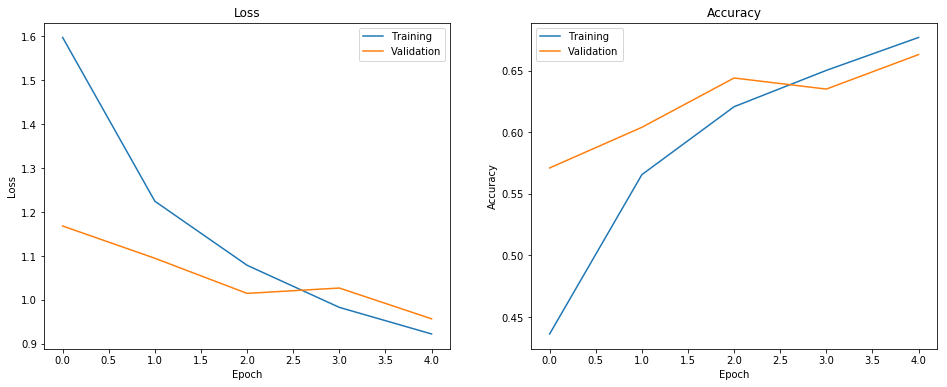

In [29]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

### Feature extraction

Model trained for classification can be used in other creative ways, for example finding similar images. The hidden layer activations can be thought of as features extracted from the images. As the final goal is to classifiy images into categories, we can assume that in the last layers the features of semantically similar images are similar. That means they are close to each other according to Euclidean distance.


When choosing which layer features to use `Dense(100)` layer seems like a good pick - it is positioned late in the network (close to output), meaning the features should reflect the semantic meaning relatively well. Also, it has sensible dimensions - 100. We create a new model that outputs not the classification, but the `Dense(100)` layer features. We can now use `predict()` to produce features of the entire test set.

Notice we are using the activation value before dropout and before relu activation function.

In [30]:
# outputs are the features from Dense(100) layer of the previously trained model
# because we do not redefine the layers, weights remain the same
extract_model = Model(inputs=x, outputs=h3)
features = extract_model.predict(X_test_norm)
features.shape

(10000, 100)

**Task 2.8 (1pt):** calculate euclidean distance matrix between test set images

In [76]:
##############################################################################
# TODO: Calculate euclidean distance matrix between test set images.         #
# You can either use code from the first homework or scipy.                  #
##############################################################################
from scipy.spatial import distance_matrix

dists = distance_matrix(features, features)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Now we take first 10 images from the test set and plot their 9 most similar images from the same set, along with distance.

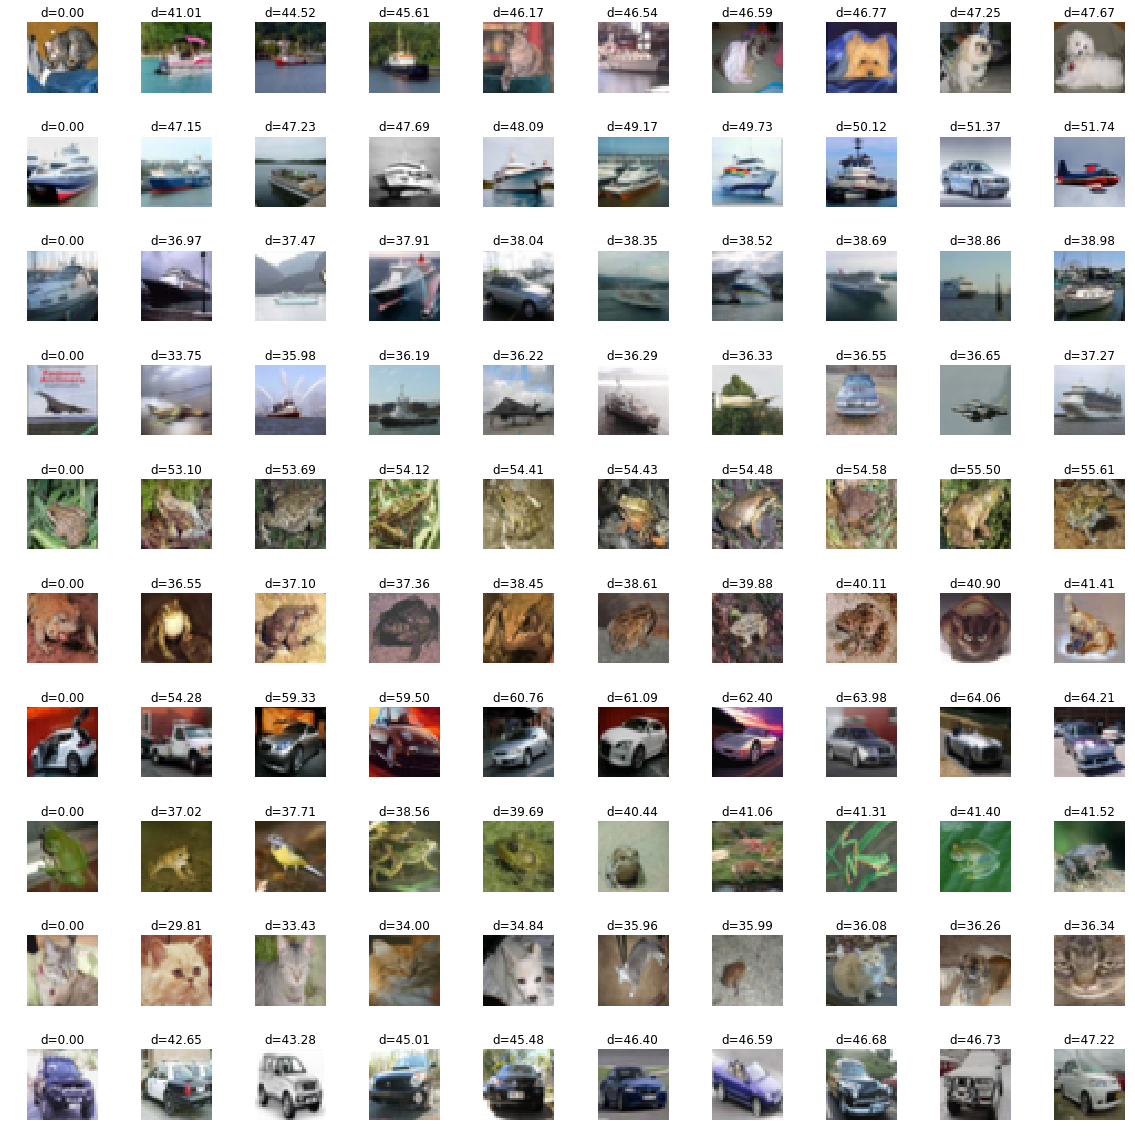

In [77]:
plt.figure(figsize=(16,16))
for i in range(10):
    closest = np.argsort(dists[i])[:10]
    for k, j in enumerate(closest):
        plt.subplot(10, 10, i*10 + k + 1)
        plt.imshow(X_test[j])
        plt.axis('off')
        plt.title("d=%0.2f" % dists[i, j])
plt.tight_layout()

**Task 2.9 (2pts):** Describe the results. Describe the mistakes it makes. A nearest-neighbour search on the input images would simply return images with most similar pixel values, how are these results different?  

**Your answer:** Overall, the use of extracted features for looking for similar images gives much better results than the use of nearest-neighbour, because it uses not only similar pixel values, but also the features of particular categories. However, it makes some mistakes, mixing up birds and frogs, for instance, probably because of similar background. In addition, some planes, cars and ships are mixed up having similar background and object colors. Cats and dogs are also mixed up sometimes. The similar car images are found almost perfectly as well as frog images. The quality of some of the images doesn't allow to determine the category exactly even for a human, that's why the closest images for some of the test images might appear really diverse.